# Import Lib

In [152]:
import sys
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

from sklearn.decomposition import PCA

import open3d as o3d
import alphashape
from descartes import PolygonPatch
from shapely.geometry import Polygon
from shapely import affinity



In [153]:
# switch for figure
show_figure = True

# add aixs
aix_points = [[0, 0, 0],
              [0, 0, 100],
              [400, 0, 0],
              [0, 100, 0],
              [-400, 0, 0],]
aix_lines = [[0, 1], # z-aix
             [0, 2], # x-aix
             [0, 3]] # y-aix

colors = [[1,0,1], [0,0,0], [0,0,0]]
aix_line_set = o3d.geometry.LineSet(points=o3d.utility.Vector3dVector(aix_points),
                                    lines=o3d.utility.Vector2iVector(aix_lines))
aix_line_set.colors = o3d.utility.Vector3dVector(colors)

# Read scan model
## import obj file

In [154]:
scan_obj = o3d.io.read_triangle_mesh("../data/humerus/humerus_multi_perspective.obj")
print(scan_obj)
o3d.visualization.draw_geometries([scan_obj], mesh_show_wireframe=True)

geometry::TriangleMesh with 17288 points and 33585 triangles.


## Scale unit length to 1mm (coordinate 1000x)

In [155]:
points_center = scan_obj.get_center()
print(points_center)
scan_obj.scale(1000.0, points_center)

[ 0.17768494 -0.34928548 -0.17509708]


geometry::TriangleMesh with 17288 points and 33585 triangles.

## change to point cloud

In [156]:
number_of_points = np.asarray(scan_obj.vertices).shape[0]
scan_obj.compute_vertex_normals()
scan_pcd = scan_obj.sample_points_uniformly(number_of_points)

In [157]:
center = scan_pcd.get_center()
center

array([ 0.30302964, -1.53263751,  0.18271267])

# --------------------------------------

## delete plane
### find plane using RANSAC: plane function: ax + by + cz + d = 0

In [158]:
plane_model, inliers = scan_pcd.segment_plane(distance_threshold=2,
                                              ransac_n=3,
                                              num_iterations=1000)
[a, b, c, d] = plane_model
plane = plane_model
print(f"Plane equation: {a:.5f}x + {b:.5f}y + {c:.5f}z + {d:.5f} = 0")

# floor
inlier_cloud = scan_pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])

# bone 
bone_cloud = scan_pcd.select_by_index(inliers, invert=True)

Plane equation: 0.00166x + 1.00000y + 0.00255z + 5.08843 = 0


## Delete outliers

In [159]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [160]:
cl, ind = bone_cloud.remove_statistical_outlier(nb_neighbors=20,
                                                std_ratio=0.5)
# display outliers
display_inlier_outlier(bone_cloud, ind)

Showing outliers (red) and inliers (gray): 


In [161]:
bone_cloud = bone_cloud.select_by_index(ind)

### project point to plane 
link:  \
https://math.stackexchange.com/questions/100761/how-do-i-find-the-projection-of-a-point-onto-a-plane


In [162]:
def point_to_plane(point, plane):
    A = plane[0]
    B = plane[1]
    C = plane[2]
    D = plane[3]

    xi = point[0]
    yi = point[1]
    zi = point[2]

    t = (A*xi + B*yi + C*zi + D) / (A**2 + B**2 + C**2)
    x = xi - A*t
    y = yi - B*t
    z = zi - C*t
    
    res = [x, y, z]
    return res

In [163]:
bone_points = np.array(bone_cloud.points)
bone_points

array([[-140.52049826,   15.95671374,   30.2504829 ],
       [-140.11438214,   14.00629555,   30.50600385],
       [-134.3636346 ,   11.9482514 ,   33.18493214],
       ...,
       [ 140.27367025,   -1.15996526,  -27.53532449],
       [ 138.34004909,   -1.19692497,  -28.71161565],
       [ 121.86078266,   -1.30449653,  -31.111195  ]])

In [164]:
proj_bone_points = []
for i in range(bone_points.shape[0]):
    point = bone_points[i]
    proj_bone_points.append(point_to_plane(point, plane))

bone_points = np.array(proj_bone_points)
bone_points

array([[-140.55510758,   -4.93256044,   30.19723535],
       [-140.14576223,   -4.93390264,   30.45772457],
       [-134.39163206,   -4.95027803,   33.14185715],
       ...,
       [ 140.26689283,   -5.25063678,  -27.54575177],
       [ 138.33334318,   -5.24443515,  -28.72193291],
       [ 121.85431034,   -5.21101701,  -31.12115287]])

In [165]:
bone_pcd = o3d.geometry.PointCloud()
bone_pcd.points = o3d.utility.Vector3dVector(bone_points)

o3d.visualization.draw_geometries([bone_pcd, aix_line_set])

### PCA


In [166]:
bone_points = bone_points - bone_points.mean(axis=0, keepdims=True)
print(bone_points)

[[-1.54499029e+02  1.70005826e-01  3.37256252e+01]
 [-1.54089684e+02  1.68663627e-01  3.39861144e+01]
 [-1.48335554e+02  1.52288239e-01  3.66702470e+01]
 ...
 [ 1.26322971e+02 -1.48070512e-01 -2.40173619e+01]
 [ 1.24389422e+02 -1.41868881e-01 -2.51935431e+01]
 [ 1.07910389e+02 -1.08450746e-01 -2.75927630e+01]]


In [167]:
pca = PCA(n_components=3)
pca.fit(bone_points)
pca.components_

array([[-0.99683318,  0.00144888,  0.07950789],
       [-0.07950383,  0.00267268, -0.99683098],
       [-0.00165679, -0.99999538, -0.00254903]])

In [168]:
x_ = pca.components_[0]
y_ =pca.components_[1]
z_ = np.cross(x_, y_)
tran_matrix = np.array([x_, y_, z_])
tran_matrix


array([[-0.99683318,  0.00144888,  0.07950789],
       [-0.07950383,  0.00267268, -0.99683098],
       [-0.00165679, -0.99999538, -0.00254903]])

In [169]:
bone_after_pca = np.dot(tran_matrix, bone_points.T).T
bone_after_pca

array([[ 1.56691459e+02, -2.13350288e+01,  6.09878293e-15],
       [ 1.56304119e+02, -2.16272406e+01,  7.21351912e-15],
       [ 1.50781597e+02, -2.47603863e+01,  7.76525842e-15],
       ...,
       [-1.27832714e+02,  1.38976944e+01,  9.85229647e-15],
       [-1.25998794e+02,  1.52238894e+01,  8.50861314e-15],
       [-1.09762656e+02,  1.89257417e+01,  9.64308195e-15]])

In [170]:
final_pcd = o3d.geometry.PointCloud()
final_pcd.points = o3d.utility.Vector3dVector(bone_after_pca)
o3d.visualization.draw_geometries([final_pcd, aix_line_set])


## save file

In [171]:
o3d.io.write_point_cloud("./data/humerus/2d_whole_humerus.ply", final_pcd)


[Open3D WARNING] Write PLY failed: unable to open file: ./data/humerus/2d_whole_humerus.ply


False

In [172]:
type(bone_after_pca)

numpy.ndarray

In [173]:
points = []
for i in range(bone_after_pca.shape[0]):
    point = bone_after_pca[i]
    x = point[0]
    y = point[1]
    points.append([x, y])


In [174]:
points = np.array(points)



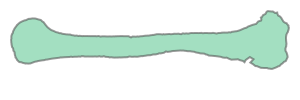

In [175]:
# todo
alpha_shape = alphashape.alphashape(points, 0.4)
# fig, ax = plt.subplots()
# ax.scatter(points[:, 0], points[:,1])
# ax.add_patch(PolygonPatch(alpha_shape, alpha=1))
# plt.show()

alpha_shape


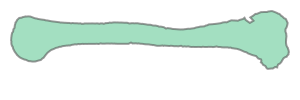

In [176]:
# todo: up and down flip
(minx, miny, maxx, maxy) = alpha_shape.exterior.bounds

x_length = maxx - minx
y_length = maxy - miny
center_box =  Polygon([(minx/5, miny), (minx/5, maxy), (maxx/5, maxy), (maxx/5, miny)])
center_bone = alpha_shape.intersection(center_box)

if (maxy - center_bone.centroid.y) > (maxy - miny) / 2:
    alpha_shape = affinity.scale(alpha_shape, xfact=1, yfact=-1, origin=(0,0))
alpha_shape

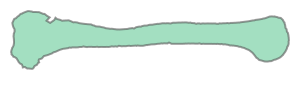

In [177]:
# left and right flip
left_box = Polygon([(minx,miny), (minx, maxy), (minx + x_length/10,maxy), (minx + x_length/10, miny)])
left_bone = alpha_shape.intersection(left_box)

right_box =  Polygon([(maxx - x_length/10, miny), (maxx - x_length/10, maxy), (maxx, maxy), (maxx, miny)])
right_bone = alpha_shape.intersection(right_box)

if left_bone.area <  right_bone.area:
    alpha_shape = affinity.scale(alpha_shape, xfact=-1, yfact=1, origin=(0,0))
alpha_shape

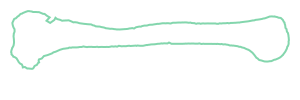

In [178]:
alpha_shape.boundary

In [179]:
type(alpha_shape.boundary)

shapely.geometry.linestring.LineString

In [180]:
alpha_shape.boundary.bounds


(-163.66397566606423, -35.54892371615544, 138.6799222995765, 27.32545707562154)

In [181]:
line = alpha_shape.exterior
type(line)


shapely.geometry.polygon.LinearRing

## Measurement

### HML

In [182]:
(minx, miny, maxx, maxy) = alpha_shape.exterior.bounds
print(minx, miny, maxx, maxy)
fml = maxx - minx
print('fml: ', fml)

-163.66397566606423 -35.54892371615544 138.6799222995765 27.32545707562154
fml:  302.34389796564074


### HEB

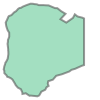

In [183]:
# todo
left_box = Polygon([(minx,miny), (minx, maxy), (minx/1.5,maxy), (minx/1.5, miny)])
left_bone = alpha_shape.intersection(left_box)
left_bone

In [184]:
(left_bone_minx, left_bone_miny, left_bone_maxx, left_bone_maxy) = left_bone.exterior.bounds
print(left_bone_minx, left_bone_miny, left_bone_maxx, left_bone_maxy)
heb = left_bone_maxy - left_bone_miny
print('heb: ', heb)

-163.66397566606423 -35.54892371615544 -109.10931711070948 27.32545707562154
heb:  62.874380791776986


### HHD

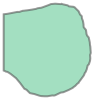

In [185]:
# todo
right_box =  Polygon([(maxx/1.5, miny), (maxx/1.5, maxy), (maxx, maxy), (maxx, miny)])
right_bone = alpha_shape.intersection(right_box)
right_bone

In [186]:
(right_bone_minx, right_bone_miny, right_bone_maxx, right_bone_maxy) = right_bone.exterior.bounds
print(right_bone_minx, right_bone_miny, right_bone_maxx, right_bone_maxy)

92.453281533051 -27.5881371939038 138.6799222995765 21.58071783002425


In [187]:
right_bone_line = right_bone.exterior

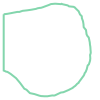

In [188]:
right_bone.boundary


In [189]:
# for x,y in right_bone_line.coords:
#     print(x, y)

In [190]:
right_bone_points = []
for x,y in right_bone_line.coords:
    right_bone_points.append([x, y])
right_bone_points = right_bone_points[:-1]
len(right_bone_points)

92

In [191]:
max_diff_y = 0
a_idx = 0
for i in range(len(right_bone_points) - 1):
    diff_cur = abs(right_bone_points[i][1] - right_bone_points[i+1][1])
    if  diff_cur > max_diff_y:
        max_diff_y = diff_cur
        a_idx = i

diff_last = abs(right_bone_points[len(right_bone_points) - 1][1] - right_bone_points[0][1])
if diff_last > max_diff_y:
    max_diff_y = diff_last
    a_idx = len(right_bone_points) - 1

print(a_idx)
print(max_diff_y)
point_a = right_bone_points[a_idx]
point_b = right_bone_points[(a_idx + 1) % len(right_bone_points)]

print(point_a, point_b)

91
29.900551870949677
[92.453281533051, -13.933625554400457] [92.453281533051, 15.966926316549218]


In [192]:
right_bone_points_ordered = right_bone_points[a_idx+1:] + right_bone_points[:a_idx+1]
len(right_bone_points_ordered)


92

In [193]:
#1. 假设骨头的一圈点是个list，这个list是顺时针记录的骨头的点，起点是左上角
# for i in right_bone_points_ordered:
#     print(i)

In [194]:
#2. 找到骨头最右侧的点 max(x)
(right_bone_minx, right_bone_miny, right_bone_maxx, right_bone_maxy) = right_bone.exterior.bounds
print(right_bone_minx, right_bone_miny, right_bone_maxx, right_bone_maxy)

right_most_idx = 0
for i in range(len(right_bone_points_ordered)):
    if right_bone_points_ordered[i][0] == right_bone_maxx:
        right_most_idx = i
        break
right_most_idx

92.453281533051 -27.5881371939038 138.6799222995765 21.58071783002425


47

In [195]:
#3. 以该点向上五个点开始 找到起点 start_point
start_idx = right_most_idx - 5

In [196]:
#4. 找出start_point代表的斜率为1的曲线tmp_line start_point_y = start_point_x+intercept
start_x = right_bone_points_ordered[start_idx][0]
start_y = right_bone_points_ordered[start_idx][1]
print(start_x, start_y)

# line
intercept = start_y - start_x
intercept

138.26373437635567 -0.2612290860257412


-138.5249634623814

In [197]:
#5. 从start_point开始 向下遍历点 找y=x+b 和弧线的另一个交点
# line p1: (start_x, start_y), p2:(0, intercept), p3: tmp_point2

def distance_point_to_line(p1, p2, p3):
    # point1 and point 2 formed a line, dis is point to that line
    p1 = np.asarray(p1)
    p2 = np.asarray(p2)
    p3 = np.asarray(p3)
    return np.abs(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

p_start = [start_x, start_y]
p_y_inter = [0, intercept]

# right: True; left : False
side = True
end_idx = start_idx + 3
while end_idx < len(right_bone_points_ordered):
    cur_x = right_bone_points_ordered[end_idx][0]
    cur_y = right_bone_points_ordered[end_idx][1]

    if cur_x + intercept > cur_y:
        side = True
    else:
        side = False

    if not side:
        break
    end_idx += 1

line_right_point = [right_bone_points_ordered[end_idx - 1][0], right_bone_points_ordered[end_idx - 1][1]]
line_left_point = [right_bone_points_ordered[end_idx][0], right_bone_points_ordered[end_idx][1]]
print(line_left_point, line_right_point)

dis_right_point = distance_point_to_line(p_start, p_y_inter, line_right_point)
dis_left_point = distance_point_to_line(p_start, p_y_inter, line_left_point)

print(dis_left_point, dis_right_point)

p_start_2 = line_left_point
p_start_2_idx = end_idx
if dis_left_point > dis_right_point:
    p_start_2 = line_right_point
    p_start_2_idx = end_idx - 1

print('start: ', p_start)
print('start2: ', p_start_2)


[108.77627712503805, -26.410326955309365] [111.5289176357023, -27.29640015800186]
2.3605765570739705 0.2123825844370655
start:  [138.26373437635567, -0.2612290860257412]
start2:  [111.5289176357023, -27.29640015800186]


In [198]:
#6. 计算出点tmp_point2到 tmp_line上的投影点tmp_point3 然后算出来 start_point到tmp_point3的距离dist
# 把dist存入一个list
def distance_point_to_point(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

fhd = distance_point_to_point(p_start, p_start_2)
count_decrease = 0
# pre_fhd = fhd
# pre_down_left = p_start_2
# pre_down_left_idx = p_start_2_idx

In [199]:
#7. start_point开始，向上遍历点 tmp_point1， 更新tmp_line   tmp_point1_y = tmp1_point_x+b
#8. 每次遍历，找到在上次tmp_point2附近的一个新点，使得新点到直线tmp_line距离最短
# tmp_point2更新为新的点，然后计算tmp_point2在直线tmp_line上的投影tmp_point3 到 tmp_point1的距离，存入dist list
# 依次循环,dist应该先增大，后减小，我们要找到的就是增到极大值，开始减小时候的那个极大的距离


def find_down_left(p1, from_idx, right_bone_points_ordered_array):
    cur_intercept = p1[1] - p1[0]
    right_side = True
    while right_side and from_idx < len(right_bone_points_ordered_array):
        candidate_x = right_bone_points_ordered_array[from_idx][0]
        candidate_y = right_bone_points_ordered_array[from_idx][1]
        if candidate_x + cur_intercept <= candidate_y:
            right_side = False
        from_idx += 1

    if from_idx == len(right_bone_points_ordered_array):
        return None
    left_idx = from_idx - 1
    right_idx = left_idx - 1
    left_dis = distance_point_to_line(p1, [0, cur_intercept], right_bone_points_ordered_array[left_idx])
    right_dis = distance_point_to_line(p1, [0, cur_intercept], right_bone_points_ordered_array[right_idx])

    res_point = right_bone_points_ordered_array[left_idx]
    if left_dis > right_dis:
        res_point = right_bone_points_ordered_array[right_idx]

    return res_point

In [200]:
iterate_idx = start_idx - 1
while iterate_idx >= 0:
    p_up_right = right_bone_points_ordered[iterate_idx]

    p_down_left = find_down_left(p_up_right, p_start_2_idx, right_bone_points_ordered)
    if p_down_left is None :
        break
    cur_fhd = distance_point_to_point(p_up_right, p_down_left)
    fhd = max(fhd, cur_fhd)
    if cur_fhd < fhd:
        count_decrease += 1
        if count_decrease >= 3:
            break
    else:
        count_decrease = 0
    iterate_idx -= 1

print('fhd: ', fhd)
print(iterate_idx)

fhd:  49.30001003508738
22
